In [3]:
!pip install open3d

  Using cached open3d-0.18.0-cp310-cp310-manylinux_2_27_x86_64.whl (399.7 MB)
  Using cached ipywidgets-8.1.5-py3-none-any.whl (139 kB)
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 8.0.2
    Uninstalling ipywidgets-8.0.2:
      Successfully uninstalled ipywidgets-8.0.2


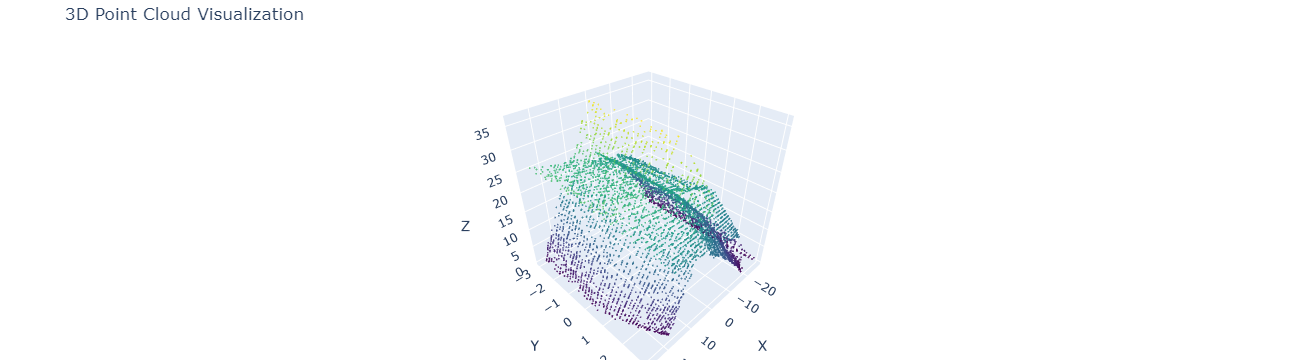

In [193]:
import numpy as np
import open3d as o3d
import numpy as np
import plotly.graph_objs as go
from plotly.offline import plot
from IPython.display import display



# Function to create a transformation matrix from rotation and translation
def create_transformation_matrix(rotation, translation):
    transformation = np.eye(4)
    transformation[:3, :3] = rotation  # Assign rotation
    transformation[:3, 3] = translation  # Assign translation
    return transformation

# Function to transform a point cloud using a transformation matrix
def transform_point_cloud(pcd, transformation):
    pcd.transform(transformation)  # Apply the 4x4 transformation
    return pcd
# Load the point cloud from the uploaded .ply file
pcd = o3d.io.read_point_cloud("./data/pointclouds/maps1/map1_0_0.ply")
points = np.asarray(pcd.points)

# Optionally, downsample the points for faster rendering
sample_rate = 20000  # Adjust as needed
if len(points) > sample_rate:
    indices = np.random.choice(len(points), sample_rate, replace=False)
    sampled_points = points[indices]
else:
    sampled_points = points

# Create Plotly scatter plot
scatter = go.Scatter3d(
    x=sampled_points[:, 0],
    y=sampled_points[:, 1],
    z=sampled_points[:, 2],
    mode='markers',
    marker=dict(
        size=1,
        color=sampled_points[:, 2],
        colorscale='Viridis',
        opacity=0.8
    )
)

layout = go.Layout(
    title='3D Point Cloud Visualization',
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z'
    ),
    margin=dict(l=0, r=0, b=0, t=40)
)

fig = go.Figure(data=[scatter], layout=layout)
fig.show()

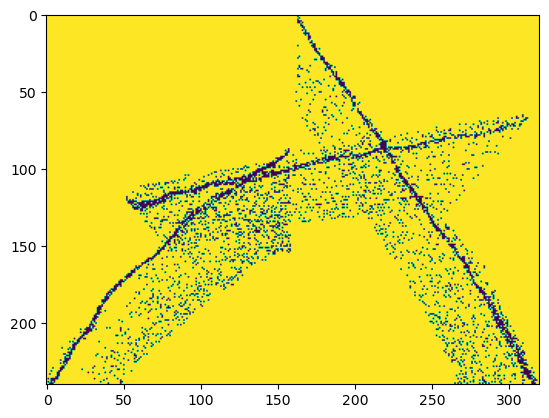

In [206]:
x = sampled_points[:, 0]
y = sampled_points[:, 2]

x = ((x - x.min())/(x.max() - x.min())) * 319
x = x.astype(np.int16)

y = ((y - y.min())/(y.max() - y.min())) * 239
y = y.astype(np.int16)

pic = np.ones((240, 320))

pic[-y, x] = np.zeros(len(y))

plt.imshow(pic)

In [204]:
pic[y,x]

array([1., 1., 1., ..., 1., 1., 1.])

In [7]:
import os

files = os.listdir("./data/pointclouds/maps1/")
dims = set()
for file in files:
    path = os.path.join("./data/pointclouds/maps1/", file)
    points = np.asarray(o3d.io.read_point_cloud(path).points)
    dims.add(points.shape[0])


dims

{5573,
 5576,
 5587,
 5595,
 5613,
 5618,
 5629,
 5631,
 5635,
 5636,
 5640,
 5641,
 5643,
 5646,
 5651,
 5652,
 5654,
 5657,
 5664,
 5665,
 5669,
 5674,
 5675,
 5676,
 5679,
 5680,
 5681,
 5682,
 5683,
 5686,
 5687,
 5689,
 5690,
 5691,
 5692,
 5693,
 5694,
 5695,
 5696,
 5698,
 5699,
 5700,
 5703,
 5706,
 5708,
 5710,
 5715,
 5718,
 5720,
 5721,
 5722,
 5724,
 5725,
 5731,
 5732,
 5734,
 5735,
 5738,
 5745,
 5751,
 5752,
 5753,
 5757,
 5758,
 5769,
 5771,
 5776,
 5785,
 5792,
 5793,
 5794,
 5795,
 5796,
 5798,
 5799,
 5801,
 5802,
 5803,
 5804,
 5805,
 5808,
 5809,
 5813,
 5814,
 5816,
 5817,
 5820,
 5823,
 5825,
 5827,
 5828,
 5829,
 5830,
 5832,
 5834,
 5837,
 5838,
 5839,
 5842,
 5843,
 5845,
 5846,
 5847,
 5850,
 5853,
 5857,
 5858,
 5859,
 5860,
 5863,
 5864,
 5865,
 5866,
 5870,
 5871,
 5872,
 5873,
 5876,
 5877,
 5878,
 5880,
 5881,
 5882,
 5884,
 5885,
 5886,
 5887,
 5889,
 5892,
 5894,
 5895,
 5896,
 5897,
 5899,
 5901,
 5903,
 5904,
 5906,
 5907,
 5911,
 5912,
 5913,
 5914,

In [8]:
data = np.load(f'./data/maps/maps1/map{1}_data.npz', allow_pickle=True)

d1 = data['maps']
d2 = data['images']
d4 = data['depth']

In [9]:
data['positions'][0, 0]

array([ 516.0163269 , 1444.1015625 ,    0.        ,   60.68298341])

In [10]:
data['images'].shape, d1.shape

((10, 4, 3, 240, 320, 3), (10, 4, 240, 320, 3))

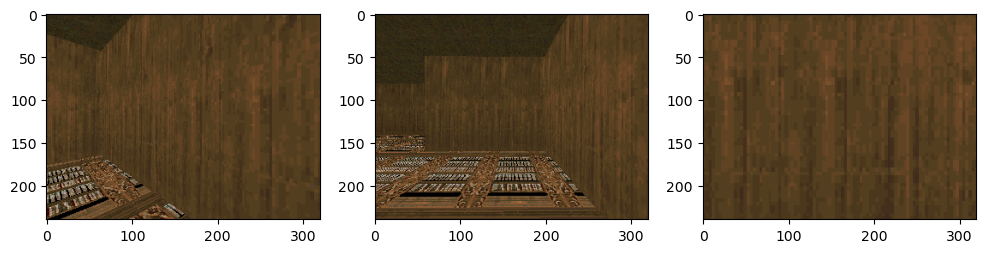

In [11]:
import matplotlib.pyplot as plt

n1, n2 = 8, 1

fig, ax = plt.subplots(ncols=3, figsize=(12, 4))
ax[0].imshow(d2[n1,n2,0])
ax[1].imshow(d2[n1,n2,1])
ax[2].imshow(d2[n1,n2,2])

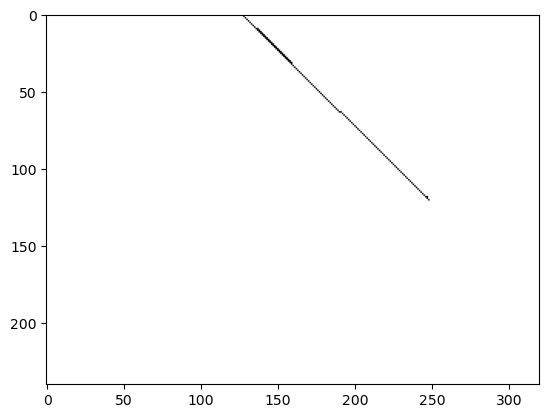

In [12]:
plt.imshow(d1[n1,n2,:,:,])

In [13]:
import torch
torch.cuda.is_available()

False

In [213]:
import torch.nn as nn
import os
from torch.utils.data import Dataset, DataLoader



class ImageMapsDataset(Dataset):
    def __init__(self, images_path, points_path):
        super().__init__()
        self.images_path = images_path
        self.points_path = points_path
        

    def __len__(self):
        return len(os.listdir(self.points_path))
    
    def _prepare_map(self, points):
        x = points[:, 0]
        y = points[:, 2]

        x = ((x - x.min())/(x.max() - x.min())) * 319
        x = x.astype(np.int16)

        y = ((y - y.min())/(y.max() - y.min())) * 239
        y = y.astype(np.int16)

        pic = np.ones((240, 320))

        pic[-y, x] = np.zeros(len(y))
        
        return pic

    def __getitem__(self, index):
        i = index // 40
        jk = index % 40
        j = jk // 4
        k = jk % 4

        data = np.load(f'{self.images_path}/map{i+1}_data.npz')
        im = data['images'][j, k]
        map = data['maps'][j, k]
        points = np.asarray(o3d.io.read_point_cloud(f"{self.points_path}/map{i+1}_0_0.ply").points)
        points_padded = np.zeros((6000, 3))
        n = points.shape[0]
        left_shift = (6000 - n) // 2
        right_shift = left_shift + (6000 - n) % 2
        points_padded[left_shift:6000-right_shift, :] = points

        im = torch.from_numpy(im) / 255
        im = im.permute(0, 3, 1, 2)

        points_padded = torch.from_numpy(points_padded.T).to(torch.float32)

        #map = torch.from_numpy(map[:, :, 0]).unsqueeze(0) / 255
        map = torch.from_numpy(self._prepare_map(points)).unsqueeze(0)

        return im, points_padded, map

        


        
images_path = "./data/maps/maps1"
points_path = "./data/pointclouds/maps1"

train_dataset = ImageMapsDataset(images_path, points_path)
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=2)


In [214]:
for b in train_loader:
    print(b[0].shape, b[1].shape, b[2].shape)
    break

torch.Size([2, 3, 3, 240, 320]) torch.Size([2, 3, 6000]) torch.Size([2, 1, 240, 320])


In [233]:
class MapGenerator(nn.Module):
    def __init__(self, ):
        super().__init__()

        self.points_encoder = nn.Sequential(
            nn.Conv1d(3, 16, 5, padding=2), # 3 x 6000
            nn.ReLU(),
            nn.AvgPool1d(2, 2),
            nn.Conv1d(16, 32, 3, padding=1), # 16 x 3000
            nn.ReLU(),
            nn.AvgPool1d(2, 2),
            nn.Conv1d(32, 32, 3, padding=1), # 32 x 1500
            nn.ReLU(),
            nn.AvgPool1d(2, 2), # 32 x 750
            nn.Flatten(1),
            nn.Linear(24_000, 8_000),
            nn.ReLU(),
            nn.Linear(8000, 4800)
        )

        self.images_encoder = nn.Sequential(
            nn.Conv3d(3, 8, 3, padding=1),
            nn.ReLU(),
            nn.AvgPool3d((1, 2, 2), (1, 2, 2)),
            nn.Conv3d(8, 16, 3, padding=1),
            nn.ReLU(),
            nn.AvgPool3d((1, 2, 2), (1, 2, 2)), 
            nn.Conv3d(16, 16, 3, padding=1),
            nn.ReLU(),
            nn.AvgPool3d((1, 2, 2), (1, 2, 2)), 
            nn.Conv3d(16, 16, 3, padding=1),
            nn.ReLU(),
            nn.AvgPool3d((1, 2, 2), (1, 2, 2)), 
            nn.Flatten(1),
            nn.Linear(14_400, 8_000),
            nn.ReLU(),
            nn.Linear(8_000, 4_800)
        )
        
        self.make_embedding = nn.Sequential(
            nn.Linear(4_800*2, 4_800)
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(16, 8, kernel_size=2, stride=2),
            nn.Conv2d(8, 8, kernel_size=3, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 4, kernel_size=2, stride=2),
            nn.Conv2d(4, 4, kernel_size=3, padding=1),
            nn.BatchNorm2d(4),
            nn.ReLU(),
            nn.ConvTranspose2d(4, 2, kernel_size=2, stride=2),
            nn.Conv2d(2, 2, kernel_size=3, padding=1),
            nn.BatchNorm2d(2),
            nn.ReLU(),
            nn.ConvTranspose2d(2, 1, kernel_size=2, stride=2),
        )

    def forward(self, ims, points):
        ims = self.images_encoder(ims)
        points = self.points_encoder(points)
        #points = 0
        x = self.make_embedding(torch.cat((ims, points), axis=1))
        x = x.view(-1, 16, 15, 20)
        x = self.decoder(x)
        return x
    

    


In [222]:
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=2)
ex = None
for b in train_loader:
    ex = b
    break

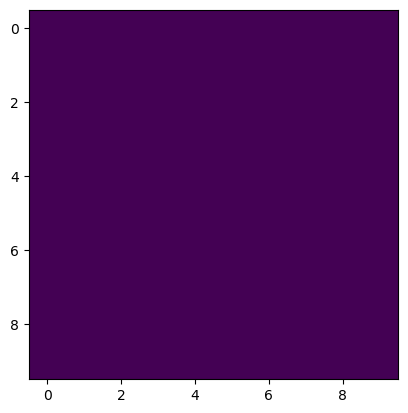

In [223]:
map = ex[-1][0, 0]
plt.imshow(np.ones((10, 10)))

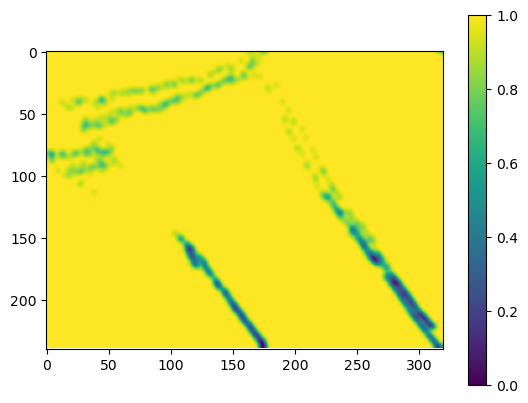

In [224]:
from torchvision.transforms import GaussianBlur

gb = GaussianBlur(kernel_size=9, sigma=2)
gb_map = gb(map.view(1, 240, 320))
gb_map = (gb_map - gb_map.min()) / (gb_map.max() - gb_map.min())
plt.imshow(gb_map[0])
plt.colorbar()

In [110]:
gb(map.view(1, 240, 320))[0]

tensor([[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        ...,
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]])

In [58]:
map[100:120, 196:204]

tensor([[0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039],
        [0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039],
        [0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039],
        [0.0000, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039],
        [0.0039, 0.0000, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039],
        [0.0039, 0.0000, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039],
        [0.0039, 0.0039, 0.0000, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039],
        [0.0039, 0.0039, 0.0000, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039],
        [0.0039, 0.0039, 0.0039, 0.0000, 0.0039, 0.0039, 0.0039, 0.0039],
        [0.0039, 0.0039, 0.0039, 0.0000, 0.0039, 0.0039, 0.0039, 0.0039],
        [0.0039, 0.0039, 0.0039, 0.0039, 0.0000, 0.0039, 0.0039, 0.0039],
        [0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0000, 0.0039, 0.0039],
        [0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0000, 0.0039, 0.0039],
        [0.0039, 0.0039, 0.0039, 0.003

In [22]:
loss = nn.BCELoss()

loss(gb(map[100:120, 198:205].view(1, 20, 7)), map[100:120, 198:205].view(1, 20, 7))

tensor(0.0238)

In [225]:
def gauss_pixel_loss(y_true, y_pred, loss_fn):
    EPS = 1e-7
    gb = GaussianBlur(kernel_size=17, sigma=8)
    y_true = gb(y_true)
    y_true = (y_true - y_true.min()) / (y_true.max() - y_true.min() + EPS)
    return loss_fn(y_pred, y_true)

In [226]:
class diceloss(torch.nn.Module):
    def init(self):
        super(diceLoss, self).init()
    def forward(self,pred, target):
        smooth = 1.
        iflat = pred.contiguous().view(-1)
        tflat = target.contiguous().view(-1)
        intersection = (iflat * tflat).sum()
        A_sum = torch.sum(iflat * iflat)
        B_sum = torch.sum(tflat * tflat)
        return 1 - ((2. * intersection + smooth) / (A_sum + B_sum + smooth) )

In [227]:
def dice_loss(pred,target):
    numerator = 2 * torch.sum(pred * target)
    denominator = torch.sum(pred + target)
    return 1 - (numerator + 1) / (denominator + 1)

  0%|          | 0/7 [00:00<?, ?it/s]

tensor(0.4877, dtype=torch.float64,
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.4797, dtype=torch.float64,
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.4735, dtype=torch.float64,
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.4665, dtype=torch.float64,
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


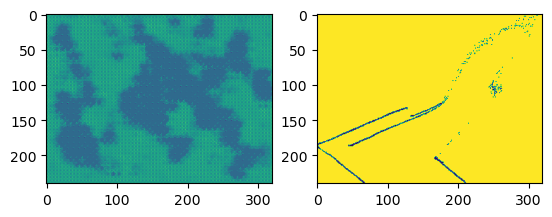

tensor(0.4573, dtype=torch.float64,
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.4496, dtype=torch.float64,
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.4423, dtype=torch.float64,
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.4342, dtype=torch.float64,
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


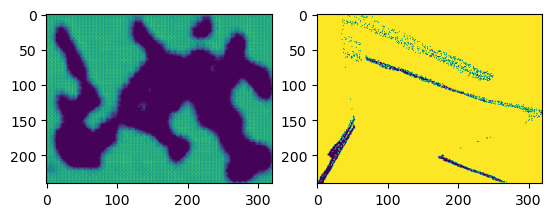

tensor(0.4267, dtype=torch.float64,
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.4181, dtype=torch.float64,
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.4135, dtype=torch.float64,
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.4040, dtype=torch.float64,
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


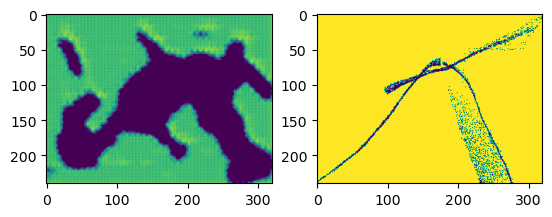

tensor(0.3999, dtype=torch.float64,
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.3932, dtype=torch.float64,
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.3876, dtype=torch.float64,
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.3817, dtype=torch.float64,
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


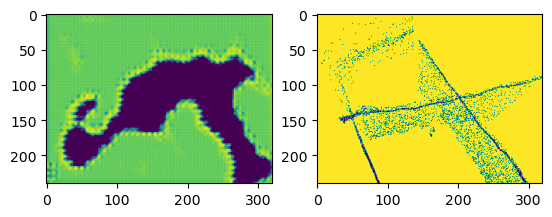

tensor(0.3791, dtype=torch.float64,
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.3770, dtype=torch.float64,
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.3720, dtype=torch.float64,
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.3691, dtype=torch.float64,
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


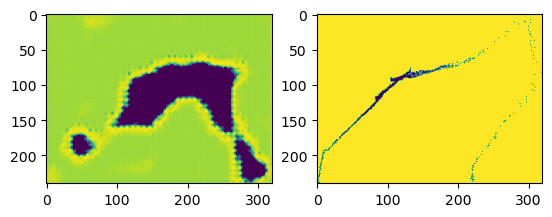

tensor(0.3673, dtype=torch.float64,
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.3658, dtype=torch.float64,
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.3632, dtype=torch.float64,
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.3615, dtype=torch.float64,
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


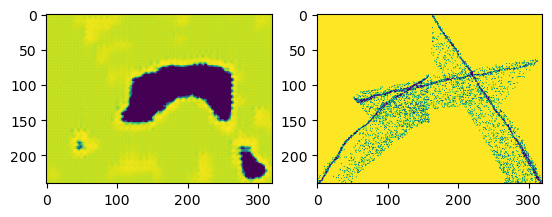

tensor(0.3581, dtype=torch.float64,
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.3607, dtype=torch.float64,
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.3588, dtype=torch.float64,
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.3588, dtype=torch.float64,
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


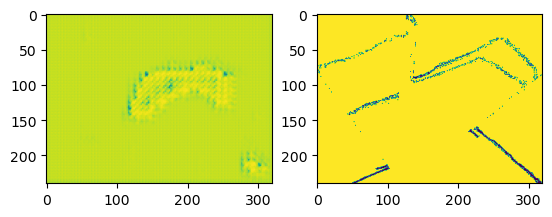

In [235]:
from tqdm.auto import tqdm

torch.cuda.empty_cache()

train_loader = DataLoader(train_dataset, shuffle=True, batch_size=250)
model = MapGenerator()
losses = []
max_epoch = 7
device = torch.device('cpu')
loss_fn = nn.BCEWithLogitsLoss()

model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-2)

for _ in tqdm(range(max_epoch)):
    model.train()
    for ims, points, maps in train_loader:
        optimizer.zero_grad()
        ims, points, maps = ims.to(device), points.to(device), maps.to(device)
        output = model(ims, points)
        output = torch.sigmoid(output)
        loss = gauss_pixel_loss(maps, output, loss_fn)
        print(loss)
        loss.backward()
        losses.append(loss.detach().cpu().numpy())
        optimizer.step()

    fig, ax = plt.subplots(ncols=2)
    ex = output[0].detach().cpu().numpy()[0]
    mp = maps[0].detach().cpu().numpy()[0]
    ax[0].imshow(ex)
    ax[1].imshow(mp)
    
    plt.show()



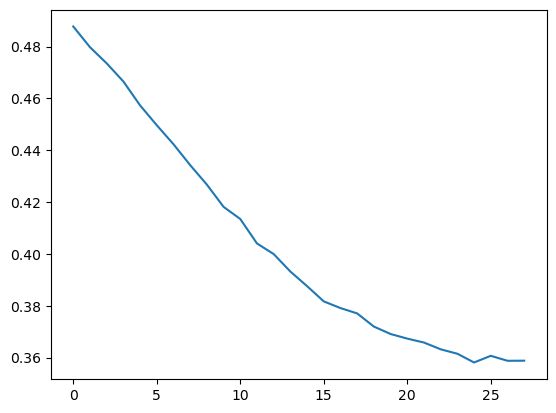

In [236]:
plt.plot(losses)

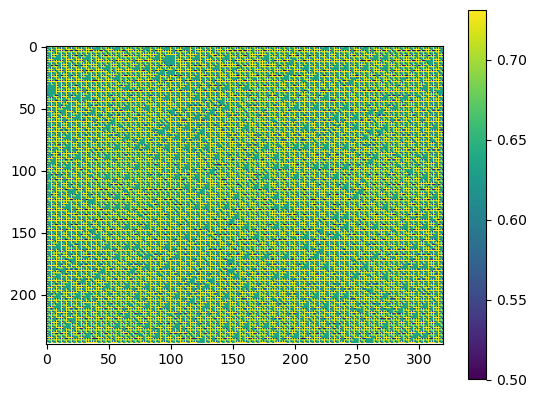

In [192]:
plt.imshow(torch.sigmoid(torch.from_numpy(ex)))
plt.colorbar()